In [1]:
import os
from gait_modulation.file_reader import MatFileReader
import matplotlib.pyplot as plt

# Loading the data

In [2]:
mat_files_directory = '/Users/orabe/Library/Mobile Documents/com~apple~CloudDocs/0_TU/Master/master_thesis/Chiara/data/EM_FH_HK/PW_EM59/21_07_2023'

mat_reader = MatFileReader(mat_files_directory)
data = mat_reader.read_data()
trial4_lfp, trial3_lfp = data[0], data[1]

Loading data from file: EM_FH_HK/PW_EM59/21_07_2023/walking_sync_4_short.mat
Loading data from file: EM_FH_HK/PW_EM59/21_07_2023/walking_sync_3_short.mat


In [3]:
lfp_data = trial3_lfp['data_LFP']
n_channels, n_times = lfp_data.shape
n_channels, n_times

(6, 43382)

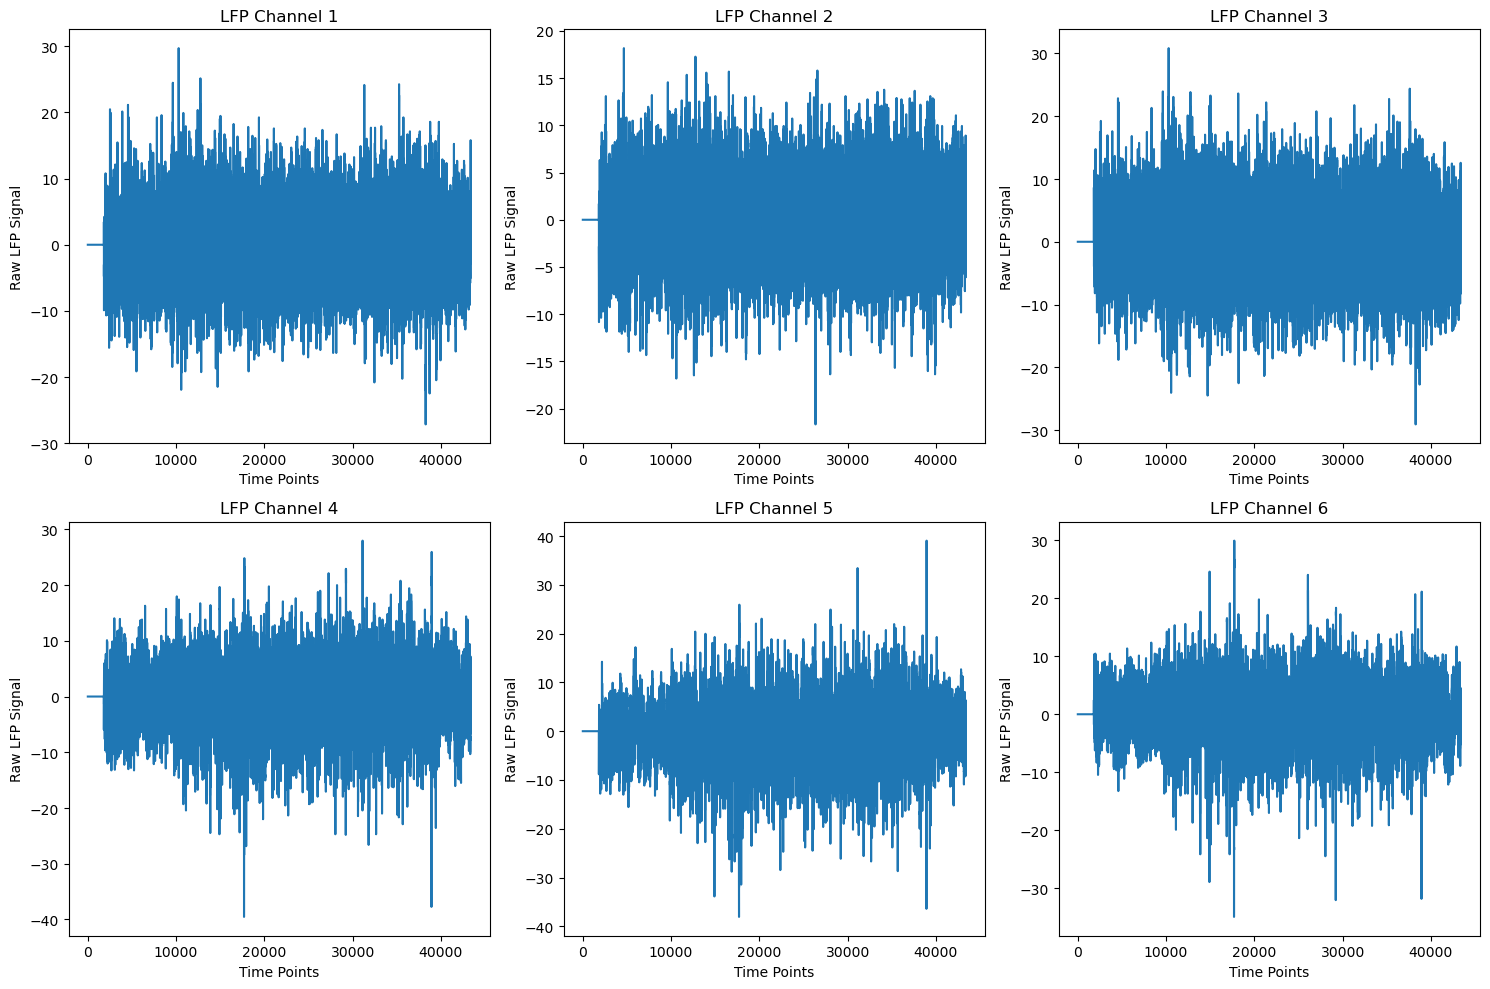

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for channel in range(n_channels):
    axes[channel].plot(lfp_data[channel, :])
    axes[channel].set_title(f'LFP Channel {channel + 1}')
    axes[channel].set_xlabel('Time Points')
    axes[channel].set_ylabel('Raw LFP Signal')

plt.tight_layout()
plt.show()